# Mise en place d’une méthode pour la visualisation des représentations internes basées sur des réseaux convolutifs
RCP 209 - Semestre 1 2024/2025 - Nicolas Guillard

CNAM RCP209 2024/25 Project : replication of paper "Zeiler and al. 2013" © 2024 by Nicolas Guillard is licensed under <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/?ref=chooser-v1" target="_blank" rel="license noopener noreferrer" style="display:inline-block;">CC BY-NC-SA 4.0<img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/cc.svg?ref=chooser-v1" alt=""><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/by.svg?ref=chooser-v1" alt=""><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/nc.svg?ref=chooser-v1" alt=""><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/sa.svg?ref=chooser-v1" alt=""></a>

Les instructions de ce carnet reposent sur la librairie Pytorch v2.2.2.

In [1]:
import os
from typing import Tuple, List

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchinfo import summary
from torchvision import transforms as T
import torchvision.transforms.functional as F
from torchvision.io import read_image

from cnn_features_handler import CNNFeaturesHandler
from deconvnet_processor import DeconvnetProcessor


In [2]:
print(torch.__version__)

2.2.2


# Utiles

In [3]:
def display_pictures_grid(pictures: torch.Tensor, per_rows: int, titles: List[str]=None, suptitle: str="", figsize: Tuple[int, int]=(12, 12)) -> None:
    """ 
    Display a grid of pictures
    
    - Arg(s):
        pictures: torch.Tensor
            Shape (n, C, H, W)
        per_rows: int
        titles: List[str]
            Shape (n) or None
        suptitle: str
        figsize: Tuple[int, int]
    """
    fig = plt.figure(figsize=figsize, layout='constrained')
    plt.rcParams['axes.titley'] = 1.0
    plt.rcParams['axes.titlepad'] = 1.2
    rows = pictures.size(0) // per_rows + 1
    for r in range(rows):
        for c in range(per_rows):
            i = r * per_rows + c
            if i < len(pictures):
                ax = fig.add_subplot(rows, per_rows, i+1, xticks = [], yticks = [])
                if titles:
                    ax.set_title(titles[i])
                ax.imshow(pictures[i].numpy().transpose(1, 2, 0))
    if suptitle:
        plt.suptitle(suptitle)
    #plt.tight_layout()
    #plt.subplots_adjust(hspace=1)
    plt.show()

In [4]:
def i_suffix(i, he=True):
    f = "er" if he else "ère"
    return f if i==1 else "ème"

# Modèles de test

Les modèles convolutifs [`AlexNet`](https://pytorch.org/hub/pytorch_vision_alexnet/) et [`VGG16`](https://pytorch.org/hub/pytorch_vision_vgg/) utilisés sont instanciés avec les poids obtenus par entrainement sur le jeu de données `ImageNet`.

In [5]:
cnn_models = {}

### Modèle Alexnet

Description des couches du réseau :

In [6]:
cnn_models["alexnet"] = models.alexnet(weights='IMAGENET1K_V1')
cnn_models["alexnet"].eval()
cnn_models["alexnet"].features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

Evaluation des dimensions des sorties de chaque couches pour la partie convolution (*features*) du réseau.

In [7]:
summary(cnn_models["alexnet"].features, input_size=torch.Size([1, 3, 224, 224]))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 256, 6, 6]            --
├─Conv2d: 1-1                            [1, 64, 55, 55]           23,296
├─ReLU: 1-2                              [1, 64, 55, 55]           --
├─MaxPool2d: 1-3                         [1, 64, 27, 27]           --
├─Conv2d: 1-4                            [1, 192, 27, 27]          307,392
├─ReLU: 1-5                              [1, 192, 27, 27]          --
├─MaxPool2d: 1-6                         [1, 192, 13, 13]          --
├─Conv2d: 1-7                            [1, 384, 13, 13]          663,936
├─ReLU: 1-8                              [1, 384, 13, 13]          --
├─Conv2d: 1-9                            [1, 256, 13, 13]          884,992
├─ReLU: 1-10                             [1, 256, 13, 13]          --
├─Conv2d: 1-11                           [1, 256, 13, 13]          590,080
├─ReLU: 1-12                             [1, 256, 13, 13]    

Export pour la visualisation de l'architecture du réseau AlexNet avec l'outil en ligne [Netron](https://netron.app/).

In [8]:
scripted = torch.jit.script(cnn_models["alexnet"].features)
torch.jit.save(scripted, "alexnet.pt")

### Modèle VGG16

Description des couches du réseau :

In [9]:
cnn_models["vgg16"] = models.vgg16(weights='IMAGENET1K_V1')
cnn_models["vgg16"].eval()
cnn_models["vgg16"].features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

Evaluation des dimensions des sorties de chaque couches pour la partie convolution (*features*) du réseau.

In [10]:
summary(cnn_models["vgg16"].features, input_size=torch.Size([1, 3, 224, 224]))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 512, 7, 7]            --
├─Conv2d: 1-1                            [1, 64, 224, 224]         1,792
├─ReLU: 1-2                              [1, 64, 224, 224]         --
├─Conv2d: 1-3                            [1, 64, 224, 224]         36,928
├─ReLU: 1-4                              [1, 64, 224, 224]         --
├─MaxPool2d: 1-5                         [1, 64, 112, 112]         --
├─Conv2d: 1-6                            [1, 128, 112, 112]        73,856
├─ReLU: 1-7                              [1, 128, 112, 112]        --
├─Conv2d: 1-8                            [1, 128, 112, 112]        147,584
├─ReLU: 1-9                              [1, 128, 112, 112]        --
├─MaxPool2d: 1-10                        [1, 128, 56, 56]          --
├─Conv2d: 1-11                           [1, 256, 56, 56]          295,168
├─ReLU: 1-12                             [1, 256, 56, 56]       

Export pour la visualisation de l'architecture du réseau VGG16 avec l'outil en ligne [Netron](https://netron.app/).

In [11]:
scripted = torch.jit.script(cnn_models["vgg16"].features)
torch.jit.save(scripted, "vgg16.pt")

# Le jeu de données : ImageNet

Selon la capacité de stockage, le jeu de données est à choisir parmi :
- Un extrait de [1000 images](https://github.com/EliSchwartz/imagenet-sample-images) d'ImageNet, une par classe, appartenant au jeu complet de données
    - fichier à télécharger : https://github.com/EliSchwartz/imagenet-sample-images/archive/refs/heads/master.zip
- Un des [jeux d'images officiels d'ImageNet](https://huggingface.co/datasets/imagenet-1k/tree/main/data) disponibles sur HuggingFace, dont le jeu d'évaluation de 50000 images utilisé durant la phase d'entrainement
    - fichier à télécharger : https://huggingface.co/datasets/imagenet-1k/blob/main/data/val_images.tar.gz


> Pour ce carnet, c'est l'extrait de 1000 images qui est utilisé.

Les images sont stockées dans un répertoire indiqué dans la variable `DataPath` à modifier selon son environnement de travail.

In [12]:
DataPath = "/Users/me/Documents/Work/Dev/_data/imagenet-sample-images-master"

On constate que les images au format jpeg sont soit des images RVB à valeur sur 8 bits, ou bien des images en niveau de gris sur 8 bits.

### Une image RVB

In [13]:
image_file = "n02128757_snow_leopard.JPEG" #"ILSVRC2012_val_00038102_n01756291.JPEG" #"ILSVRC2012_val_00001971_n02105855.JPEG"
filename = os.path.join(DataPath, image_file)
img_rgb = read_image(filename)
img_rgb

tensor([[[145, 149, 148,  ..., 141, 143, 146],
         [148, 142, 137,  ..., 149, 147, 136],
         [148, 151, 143,  ..., 142, 148, 147],
         ...,
         [215, 215, 189,  ..., 214, 210, 209],
         [192, 222, 213,  ..., 212, 210, 217],
         [147, 182, 199,  ..., 218, 224, 226]],

        [[131, 135, 134,  ..., 124, 126, 129],
         [134, 128, 123,  ..., 132, 130, 119],
         [134, 137, 129,  ..., 125, 131, 130],
         ...,
         [195, 201, 177,  ..., 199, 195, 194],
         [175, 207, 200,  ..., 203, 201, 208],
         [127, 167, 182,  ..., 208, 215, 217]],

        [[102, 106, 105,  ...,  80,  82,  85],
         [105,  99,  94,  ...,  88,  86,  75],
         [105, 108, 100,  ...,  81,  87,  86],
         ...,
         [168, 162, 137,  ..., 170, 164, 163],
         [131, 176, 168,  ..., 170, 168, 175],
         [ 64, 124, 154,  ..., 181, 186, 186]]], dtype=torch.uint8)

Taille : torch.Size([3, 345, 500]) - Valeur max:  255


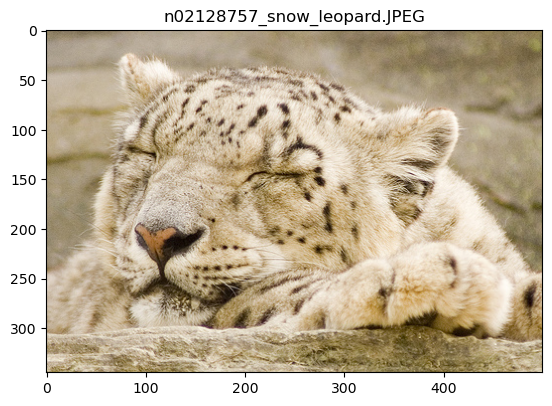

In [14]:
print("Taille :", img_rgb.size(), "- Valeur max: ", img_rgb.max().item())
plt.imshow(img_rgb.permute(1,2, 0))
plt.title("n02128757_snow_leopard.JPEG")
plt.show()

### Une image en niveau de gris

In [15]:
image_file = "n04008634_projectile.JPEG" #"ILSVRC2012_val_00038102_n01756291.JPEG" #"ILSVRC2012_val_00001971_n02105855.JPEG"
filename = os.path.join(DataPath, image_file)
img_gray = read_image(filename)
img_gray

tensor([[[221, 221, 222,  ..., 207, 208, 208],
         [221, 222, 222,  ..., 209, 210, 210],
         [221, 221, 222,  ..., 209, 210, 210],
         ...,
         [127, 117, 131,  ..., 176, 177, 175],
         [130, 117, 128,  ..., 175, 176, 174],
         [130, 116, 129,  ..., 175, 175, 173]]], dtype=torch.uint8)

Taille : torch.Size([1, 500, 334]) - Valeur max:  255


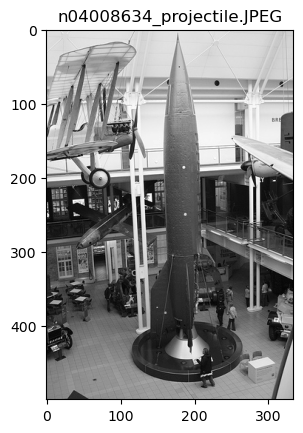

In [16]:
print("Taille :", img_gray.size(), "- Valeur max: ", img_gray.max().item())
plt.imshow(img_gray.permute(1, 2, 0), cmap="gray")
plt.title("n04008634_projectile.JPEG")
plt.show()

### Création d'une sous-classe dataset PyTorch `CustomImageDataset`

In [17]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir: str, transform: T.Compose=None, extension: str=".jpg"):
        self.img_dir = img_dir
        self.transform = transform
        self.extension = extension.lower()
        self.files = [f for f in os.listdir(img_dir) if f.lower().endswith(self.extension)]


    def __len__(self):
        return len(self.files)


    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, str]:
        img_path = os.path.join(self.img_dir, self.files[idx])
        image = read_image(img_path) # Return a torch.Tensor
        #print(self.files[idx], image.size(), end="")

        # If the image is not a RGB bit a 1 channel grey
        if image.size(0) == 1:
            #print(self.files[idx]) # Remove the comment char to print 1 channel grey image filename
            image = image.repeat(3, 1, 1)
            #print(image.size())
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.files[idx]

### Test de la classe

Avec une première instance, reposant sur une composition de transformations assurant des tailles identiques et la normalisation à $[0, 1]$ des valeurs de l'image.

In [18]:
transforms_test = transforms = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.Lambda(lambda t: t/255.),
    #T.ToTensor(),
])

imagenet_dt_test = CustomImageDataset(DataPath, transform=transforms_test, extension=".JPEG")
print(len(imagenet_dt_test), "images disponibles")

1000 images disponibles


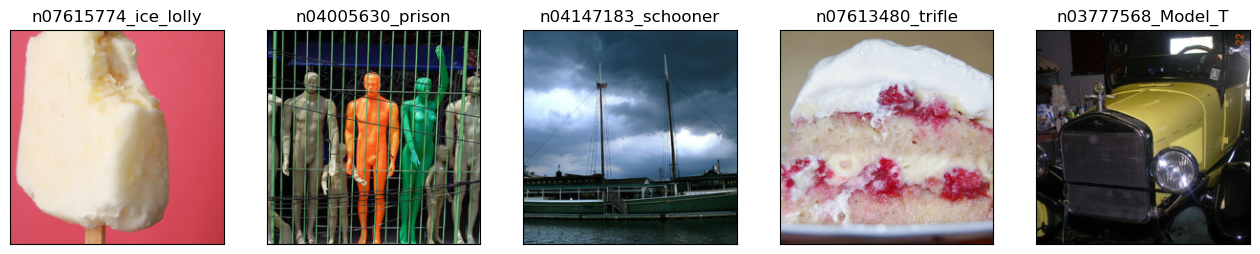

In [19]:
imageloader_test = DataLoader(imagenet_dt_test, batch_size=128)

for batch_idx, inputs in enumerate(imageloader_test):
    fig = plt.figure(figsize = (16, 8))
    for i in range(5):
        ax = fig.add_subplot(2, 5, i + 1, xticks = [], yticks = [])
        plt.title(inputs[1][i].replace("ILSVRC2012_val_", "").replace(".JPEG", ""))
        plt.imshow(inputs[0][i].numpy().transpose(1, 2, 0))
    break

### Instance du dataset pour alimenter les modèles

Comme indiqué dans la documentation des modèles Pytorch [AlexNet](https://pytorch.org/vision/main/models/generated/torchvision.models.alexnet.html) et [VGG16](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html), les images en entrée doivent subir plusieurs transformations particulières, dont une normalisation avec des valeurs de moyennes et d'écart-types fournies, à ajouter à la normalisation à $[0..1]$ :

In [20]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transforms = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.Lambda(lambda t: t/255.), # because read_image -> [0..255]
    T.Normalize(mean=imagenet_mean, std=imagenet_std),
])

imagenet_dt = CustomImageDataset(DataPath, transform=transforms, extension=".JPEG")
imageloader = DataLoader(imagenet_dt, batch_size=128)
print(len(imageloader.dataset), "images disponibles")

1000 images disponibles


## Accès aux poids des couches de convolution

### Avec AlexNet

#### Manipulation des caractéristiques

In [21]:
alexnet_handler = CNNFeaturesHandler(cnn_models["alexnet"].features)
alexnet_handler.show_feature_list()

idx:   0 - Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
idx:   1 - ReLU(inplace=True)
idx:   2 - MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
idx:   3 - Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
idx:   4 - ReLU(inplace=True)
idx:   5 - MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
idx:   6 - Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
idx:   7 - ReLU(inplace=True)
idx:   8 - Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
idx:   9 - ReLU(inplace=True)
idx:  10 - Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
idx:  11 - ReLU(inplace=True)
idx:  12 - MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)


In [22]:
alexnet_handler.summary()

input size: torch.Size([1, 3, 224, 224])
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 256, 6, 6]            --
├─Conv2d: 1-1                            [1, 64, 55, 55]           23,296
├─ReLU: 1-2                              [1, 64, 55, 55]           --
├─MaxPool2d: 1-3                         [1, 64, 27, 27]           --
├─Conv2d: 1-4                            [1, 192, 27, 27]          307,392
├─ReLU: 1-5                              [1, 192, 27, 27]          --
├─MaxPool2d: 1-6                         [1, 192, 13, 13]          --
├─Conv2d: 1-7                            [1, 384, 13, 13]          663,936
├─ReLU: 1-8                              [1, 384, 13, 13]          --
├─Conv2d: 1-9                            [1, 256, 13, 13]          884,992
├─ReLU: 1-10                             [1, 256, 13, 13]          --
├─Conv2d: 1-11                           [1, 256, 13, 13]          590,080
├─ReLU: 1-12        

Si on se concentre sur les couches de convolutions

In [23]:
alexnet_handler.show_conv_list(input_size=(224, 224))

pos:   1 - idx:   0 - Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)) - output size : {'height': 55, 'width': 55}
pos:   2 - idx:   3 - Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) - output size : {'height': 27, 'width': 27}
pos:   3 - idx:   6 - Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) - output size : {'height': 13, 'width': 13}
pos:   4 - idx:   8 - Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) - output size : {'height': 13, 'width': 13}
pos:   5 - idx:  10 - Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) - output size : {'height': 13, 'width': 13}


#### Affichage des filtres

##### De la premières couche

In [24]:
layer = alexnet_handler.get_conv_layer(1)
weights = layer.weight
print(weights.size())

torch.Size([64, 3, 11, 11])


Cette première couche de convolution contient 64 filtres en 3 dimensions, qui peuvent être interprétées comme des couches RVB pour l' affichage des filtres.

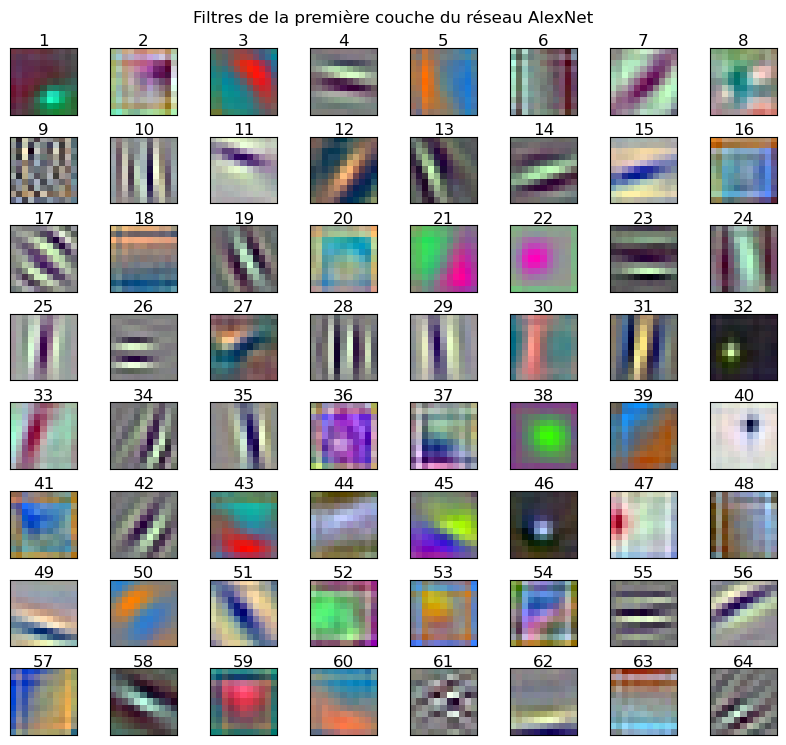

In [25]:
filters = weights.detach()
# Normalization to [0..1], like a RGB picture
for i in range(filters.size(0)):
    filters[i] = (filters[i] - filters[i].min()) / (filters[i].max() - filters[i].min())

per_rows = 8
titles=list(range(1, filters.size(0) + 1))
            
display_pictures_grid(
    filters,
    per_rows=per_rows,
    suptitle="Filtres de la première couche du réseau AlexNet", titles=titles,
    figsize=(8,8)
    )

##### D'une autre couche (la seconde)

Pour la plupart des autres couches de convolution, le nombre de dimensions excédant 3 ne permet plus une interprétation en RVB pour l'affichage. Aussi, on affichera chaque dimension en niveau de gris.

Ainsi la seconde couche de convolution est composées de 192 filtres de 64 dimensions chacun. On n'affichera que les composantes des premiers filtres.

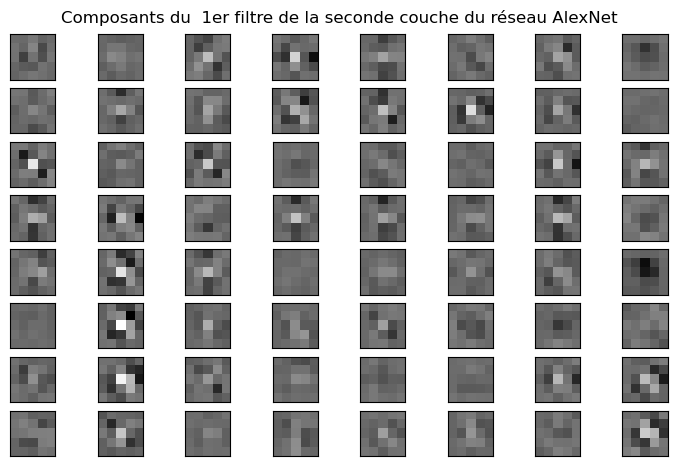

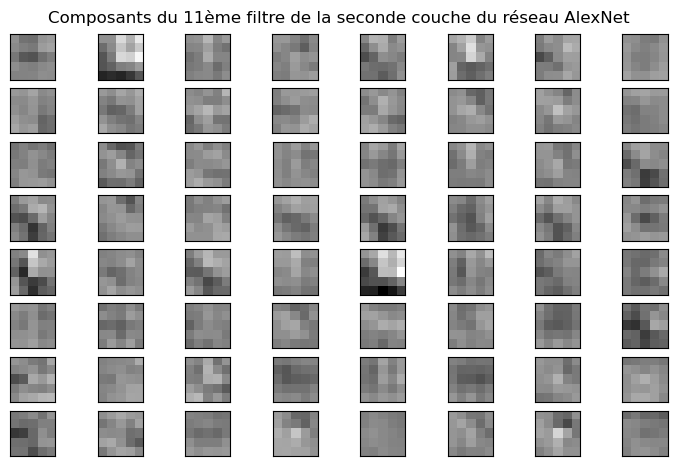

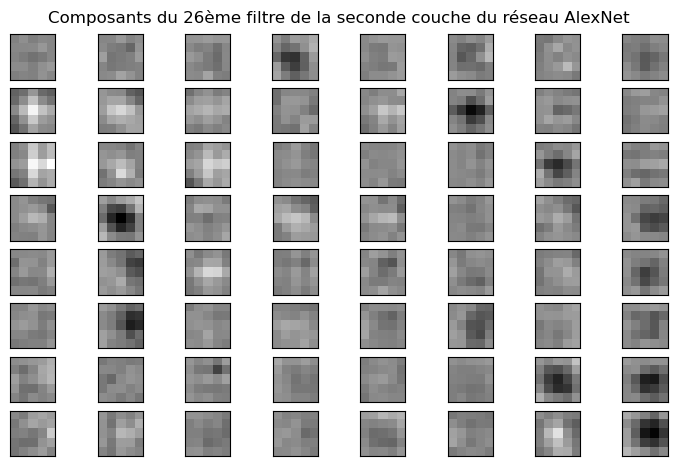

In [26]:
weights = alexnet_handler.get_conv_layer(2).weight
filters = weights.detach()
for i in range(filters.size(0)):
    filters[i] = (filters[i] - filters[i].min()) / (filters[i].max() - filters[i].min())

for idx in [0, 10, 25]:
     # From gray picture to RGB picture
    filter_components = torch.unsqueeze(filters[idx], 1).repeat(1, 3, 1, 1)
    #print(filter_components.size())
    display_pictures_grid(
        filter_components,
        per_rows=8,
        suptitle=f"Composants du {idx+1:2d}{i_suffix(idx+1)} filtre de la seconde couche du réseau AlexNet",
        figsize=(7, 5)
        )

#### Affichage des représentations internes

In [27]:
deconvnet_alexnet = DeconvnetProcessor(cnn_models["alexnet"].features)
deconvnet_alexnet.deconvnet

ModuleList(
  (0): MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
  (1): ReLU()
  (2): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): ConvTranspose2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
  (8): ReLU()
  (9): ConvTranspose2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (10): MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0))
  (11): ReLU()
  (12): ConvTranspose2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), output_padding=(1, 1))
)

##### Associées à la première couche de convolution

Détermination de la plus forte activation pour un filtre donné

0 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))


ValueError: axes don't match array

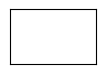

In [28]:
batch_input = transforms(img_rgb).unsqueeze(0)
feature_maps = deconvnet_alexnet.get_conv_output(batch_input, 1)
feature_maps = feature_maps.detach().squeeze()
for i in range(feature_maps.size(0)):
    feature_maps[i] = (feature_maps[i] - feature_maps[i].min()) / (feature_maps[i].max() - feature_maps[i].min())

display_pictures_grid(
        feature_maps,
        per_rows=8,
        suptitle=f"Cartes d'activation de la première couche de convolution du réseau AlexNet",
        figsize=(7, 5)
        )

- [x] Modèles utilisés : Alexnet, NGG
    -> contraintes sur les composants : Conv32d, MaxPool2d, Relu, en séquentiel

- [x] Jeu de données : extrait images jeu évaluation d'Imagenet
source HuggingFace
    - Création du dataset
    - Affichage d'une image RVB et niveau de gris
    - Création d'un dataloader ?
        - Transformations
    
- Instance de CNNFeaturesHandler
    - [x] Affichage de la stucture
    - [x] Affichage du summary pour l'estimation des dimensions des cartes d'activations en sortie

- [x] Affichage des poids des noyaux/filtres de la première couche de convolution

- [X] Affichage des poids des noyaux/filtres d'autres couches de convolution

- [ ] Affichage de la déconvolution de cartes de caractéristiques ne contenant que la plus forte activation d'un filtre donné dans une couche donnée
    - Le premier bloc de convolution
        - repérage des portions correspondant au champ récepteur, de l'image fournies en entrée

- [ ] Pour un filtre d'une couche donnée, affichage des n portions d'images d'entrées et des images de déconvolution correspondant aux n plus fortes activations


